# Customer analysis - Feature selection

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from scipy.stats import boxcox
pd.options.display.max_rows = 50
pd.options.display.max_columns = 999

## 1. Importing and initial data cleaning

In [66]:
def load_original_data():
    return pd.read_csv("Data_Marketing_Customer_Analysis_Round2.csv" )

Cleaning function:
- Standardizing column names
- Dropping some columns
- Dropping the ~630 rows that have NAN values in several columns: state and response
- Grouping the education column
- Grouping luxury cars and luxury suv in luxury
- Converting the number of open complaints in a string
- Eliminating the outliers in the customer_lifetime_value: rows where this column in bigger than 30000



In [67]:
def education_clean(value):
    dict_ed = {"Master":"Master_doctor", "Bachelor": "Bachelor", 
                   "College": "HS_College", "High School or Below": "HS_College", "Doctor": "Master_doctor"}
    return dict_ed[value]
    
def policy_clean(value):
    pol_ed = {"Personal Auto":"Personal", "Corporate Auto": "Corporate", "Special Auto": "Special"}

    return pol_ed[value]

def policy_clean_2(value):
    if "1" in value:
        return 1
    if "2" in value:
        return 2
    if "3" in value:
        return 3
    
    


def clean_data(df):
    df.columns=[e.lower().replace(' ', '_') for e in df.columns]
    df=df.drop(columns=['unnamed:_0', 'vehicle_type',"customer",
                        "effective_to_date", "months_since_last_claim", "months_since_policy_inception"])
    df.dropna(inplace=True)
    df["number_of_open_complaints"] = df["number_of_open_complaints"].astype(int)
    df["total_claim_amount"]=round(df["total_claim_amount"],0)
    df["education"] = df["education"].apply(education_clean)
    df["policy_type"] = df["policy_type"].apply(policy_clean)
    df["policy"] = df["policy"].apply(policy_clean_2)
    df["response"] = df["response"].apply(lambda x: 1 if x=="Yes" else 0)
    df.loc[df["vehicle_class"].apply(lambda x: x.startswith("Luxury")), "vehicle_class"] = "Luxury"
    df["customer_lifetime_value"]=round(df["customer_lifetime_value"],0)
    
    return df

In [68]:
#Import and clean data
customers = load_original_data()
customers = clean_data(customers)

I am dropping the rows that have income 0, because checking them we can see that they are all unemployed. So they can be useful for a separate analysis: we store their data in a dataframe for the unemployed, where income will not be a variable because it is zero for all of them.

We also store in another dataframe the rows that have a customer_lifetime_value over 30000, because they are outliers. We will call this DF over30k

In [51]:
#We store the data in two data frames and leave them for later analysis
unemployed = customers[customers["employmentstatus"] == "Unemployed"]
over30k =  customers[customers["customer_lifetime_value"] > 30000]

In [52]:
#Eliminate the relevant rows from the final customers DF
customers = customers[customers["employmentstatus"] != "Unemployed"]
customers = customers[customers["customer_lifetime_value"] < 30000]
customers.reset_index(inplace=True)

print(f"The unemployed DF has {unemployed.shape[0]} rows.")
print(f"The over30k DF has {over30k.shape[0]} rows.")
print(f"The final customers DF has {customers.shape[0]} rows and {customers.shape[1]} columns.")


The unemployed DF has 2317 rows.
The over30k DF has 189 rows.
The final customers DF has 6664 rows and 21 columns.


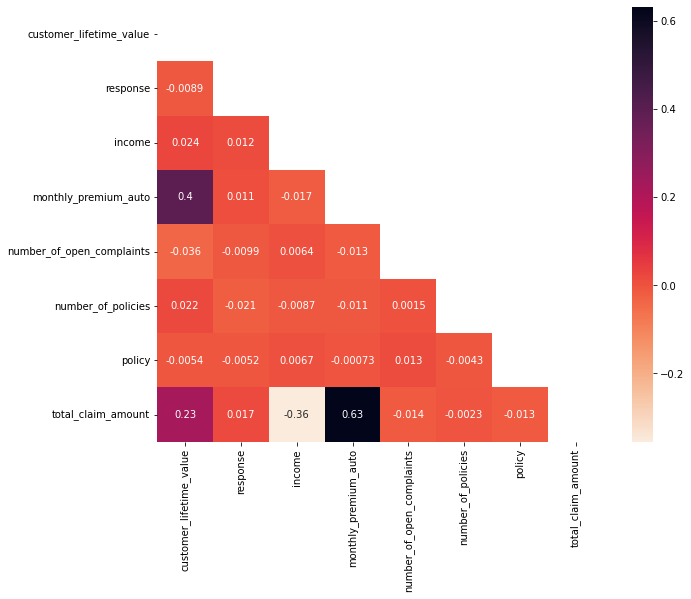

In [80]:
#numericals_features = customers_df.select_dtypes(include=np.number)
numerical_features = customers._get_numeric_data()
categorical_features = customers.select_dtypes(object)
correlations = numerical_features.corr()
cmap = sns.cm.rocket_r  ## for reversing the colors
mask=np.zeros_like(numericals_features.corr())
mask[np.triu_indices_from(mask)]=True
fig, ax=plt.subplots(figsize=(10, 8))
ax=sns.heatmap(correlations, mask=mask, annot=True,cmap=cmap)
plt.show()

## 2. Comparing regression models

We will use an evaluating function for the models

In [132]:
def evaluate(model, X_test, y_test, silent=False):
    """
    Input: a regressor, the matrix with test features, the vector with test labels.
    Output: a list with the accuracy, the R2 coefficient of determination, and the average error (absolute)
    """
    y_predict = model.predict(X_test)
    errors = abs(y_predict - y_test)
    avg_error = np.mean(errors)
    r2 = r2_score(y_test, y_predict)
    if not silent:
        print('---Model Performance---')
        print(model)
        print('\nMean Average Absolute Error: {:0.1f} dollars.'.format(avg_error))
        print('Mean squared error: %.2f' % mean_squared_error(y_test, y_predict, squared=False))
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: %.2f\n' % r2)
    
    return [r2, avg_error]

1. We separate the data using the train_test_split function

In [159]:
X = customers._get_numeric_data().drop(columns="total_claim_amount")
y = customers["total_claim_amount"]
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [91]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6850 entries, 12 to 10330
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_lifetime_value    6850 non-null   float64
 1   response                   6850 non-null   int64  
 2   income                     6850 non-null   int64  
 3   monthly_premium_auto       6850 non-null   int64  
 4   number_of_open_complaints  6850 non-null   int32  
 5   number_of_policies         6850 non-null   int64  
 6   policy                     6850 non-null   int64  
dtypes: float64(1), int32(1), int64(5)
memory usage: 401.4 KB


2. Try a simple linear regression with all the data to see whether we are getting good results.

In [99]:
regressor = LinearRegression()
scaler = StandardScaler()
pipe = make_pipeline(scaler, regressor)

In [100]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [111]:
evaluate(pipe, X_test, y_test)

---Model Performance---
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

Mean Average Absolute Error: 142.5 dollars.
Mean squared error: 203.39
Coefficient of determination: 0.52



[0.5224644529085642, 142.5332270640213]

3. Great! Now define a function that takes a list of models and train (and tests) them so we can try a lot of them without repeating code.

In [138]:
def train_eval_models(model_list, X_train, X_test, y_train, y_test):
    results_df = pd.DataFrame(columns=["model_name", "r2", "mean_absolute_error"])
    for model in model_list:
        model.fit(X_train, y_train)
        r2, mae = evaluate(model, X_test, y_test, silent=True)
        results_df = results_df.append({"model_name":model[-1].__repr__, "r2": r2,
                           "mean_absolute_error": mae}, ignore_index=True)
    return results_df
        

4. Use the function to check `LinearRegressor`,`Lasso`,`Ridge` and `KNeighborsRegressor`. We create the list of pipelines (scaler + regressor) that we will feed to the function

In [126]:
pipe1 = make_pipeline(StandardScaler(), LinearRegression())
pipe2 = make_pipeline(StandardScaler(), Lasso())
pipe3 = make_pipeline(StandardScaler(), Ridge())
pipe4 = make_pipeline(StandardScaler(), KNeighborsRegressor())
pipe_list = [pipe1, pipe2, pipe3, pipe4]

In [139]:
results = train_eval_models(pipe_list, X_train, X_test, y_train, y_test)

In [140]:
results

,model_name,r2,mean_absolute_error
0,<bound method BaseEstimator.__repr__ of Linear...,0.522464,142.533227
1,<bound method BaseEstimator.__repr__ of Lasso()>,0.522502,142.367392
2,<bound method BaseEstimator.__repr__ of Ridge()>,0.522463,142.530676
3,<bound method BaseEstimator.__repr__ of KNeigh...,0.443042,155.449562


5. Use feature selection techniques to select subset of features to train the model with(if necessary).


In [157]:
#Variance threshold
print("Initial number of numerical columns: ",X_train.shape[1])
print()


selector = VarianceThreshold(threshold=100) # Default threshold value is 0
# Features with a training-set variance lower than this threshold will be removed.
selector.fit(X_train)

kept_features_indexes = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
kept_features = list(X_train.iloc[:,kept_features_indexes].columns)

X_train = selector.transform(X_train)
X_test  = selector.transform(X_test)

X_train = pd.DataFrame(X_train, columns=kept_features)
X_test  = pd.DataFrame(X_test, columns=kept_features)

print("Final number of numerical columns: ",X_train.shape[1])
print()
X_train.info()

Initial number of numerical columns:  3

Final number of numerical columns:  3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6850 entries, 0 to 6849
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_lifetime_value  6850 non-null   float64
 1   income                   6850 non-null   float64
 2   monthly_premium_auto     6850 non-null   float64
dtypes: float64(3)
memory usage: 160.7 KB


In [160]:
#Recursive feature elimination
selector = RFE(LinearRegression(), n_features_to_select= 4, step = 1, verbose = 1) # Step is how many features to add or drop everytime
selector.fit(X_train, y_train)

kept_features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
kept_features = list(X_train.iloc[:,kept_features].columns)

X_train = selector.transform(X_train)
X_test  = selector.transform(X_test)

X_train = pd.DataFrame(X_train, columns=kept_features)
X_test  = pd.DataFrame(X_test, columns=kept_features)

print("Final selected features: ")
display(X_train.info())

Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Final selected features: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6850 entries, 0 to 6849
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   response                   6850 non-null   float64
 1   monthly_premium_auto       6850 non-null   float64
 2   number_of_open_complaints  6850 non-null   float64
 3   policy                     6850 non-null   float64
dtypes: float64(4)
memory usage: 214.2 KB


None

We try the models with this new datasets, with 4 columns:

In [162]:
pipe1 = make_pipeline(StandardScaler(), LinearRegression())
pipe2 = make_pipeline(StandardScaler(), Lasso())
pipe3 = make_pipeline(StandardScaler(), Ridge())
pipe4 = make_pipeline(StandardScaler(), KNeighborsRegressor())
pipe_list = [pipe1, pipe2, pipe3, pipe4]
results = train_eval_models(pipe_list, X_train, X_test, y_train, y_test)
results

,model_name,r2,mean_absolute_error
0,<bound method BaseEstimator.__repr__ of Linear...,0.377528,155.291979
1,<bound method BaseEstimator.__repr__ of Lasso()>,0.377614,155.062178
2,<bound method BaseEstimator.__repr__ of Ridge()>,0.377531,155.286920
3,<bound method BaseEstimator.__repr__ of KNeigh...,0.266781,175.017163
